Vegetation Health Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12068
           1       1.00      0.99      0.99       818

    accuracy                           1.00     12886
   macro avg       1.00      0.99      1.00     12886
weighted avg       1.00      1.00      1.00     12886



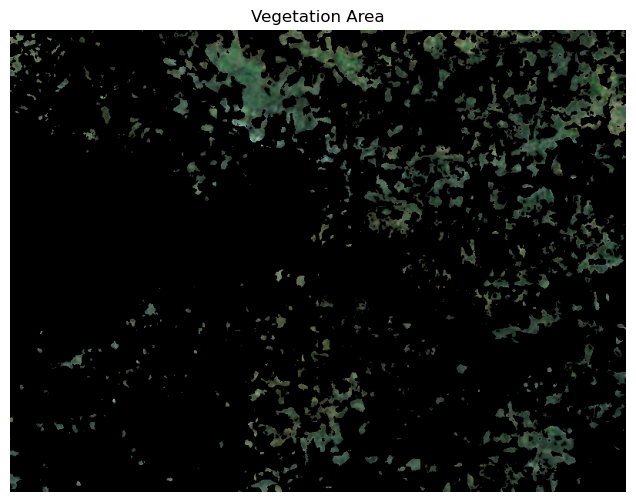

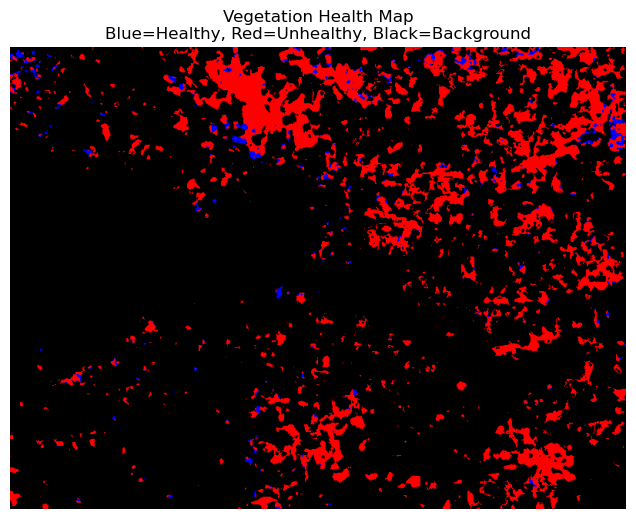

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import median
from skimage.morphology import disk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load the satellite image (ensure it's named 'original_image.png')
image_path = 'original_image.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Step 2: Resize and blur for better segmentation
resized_image = cv2.resize(image, (800, 600))
blurred_image = cv2.GaussianBlur(resized_image, (5, 5), 0)

# Step 3: Convert to HSV color space
hsv_image = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2HSV)

# Step 4: Mask vegetation using HSV range for green
lower_green = np.array([35, 50, 50])
upper_green = np.array([85, 255, 255])
veg_mask = cv2.inRange(hsv_image, lower_green, upper_green)
veg_area = cv2.bitwise_and(blurred_image, blurred_image, mask=veg_mask)

# Step 5: Prepare pixel data and synthetic labels (brightness = healthiness)
X = []
y = []
for i in range(veg_mask.shape[0]):
    for j in range(veg_mask.shape[1]):
        if veg_mask[i, j] != 0:
            pixel = blurred_image[i, j]
            X.append(pixel)
            brightness = int(np.mean(pixel))
            y.append(1 if brightness > 100 else 0)  # 1 = healthy, 0 = unhealthy

X = np.array(X)
y = np.array(y)

# Step 6: Train a Random Forest model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

# Step 7: Evaluate model
y_pred = clf.predict(X_test)
print("Vegetation Health Classification Report:")
print(classification_report(y_test, y_pred))

# Step 8: Create colored prediction map (healthy=blue, unhealthy=red)
color_map = np.zeros((veg_mask.shape[0], veg_mask.shape[1], 3), dtype=np.uint8)

for i in range(veg_mask.shape[0]):
    for j in range(veg_mask.shape[1]):
        if veg_mask[i, j] != 0:
            prediction = clf.predict([blurred_image[i, j]])[0]
            if prediction == 1:
                color_map[i, j] = [0, 0, 255]  # Blue for healthy
            else:
                color_map[i, j] = [255, 0, 0]  # Red for unhealthy
        else:
            color_map[i, j] = [0, 0, 0]  # Black for non-vegetation

# Step 9: Visualization
plt.figure(figsize=(14, 6))

plt.title("Vegetation Area")
plt.imshow(veg_area)
plt.axis('off')

plt.figure(figsize=(14, 6))
plt.title("Vegetation Health Map\nBlue=Healthy, Red=Unhealthy, Black=Background")
plt.imshow(color_map)
plt.axis('off')
plt.show()
